In [48]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"

In [49]:
df1 = pd.read_csv('bonds_info_0to3years.csv')
df2 = pd.read_csv('bonds_info_3to10years.csv')
closed_price = pd.read_csv('Copy of closed_price.csv')
combined_df = pd.concat([df1, df2])
combined_df['Maturity Date'] = pd.to_datetime(combined_df['Maturity Date'])
sorted_df = combined_df.sort_values(by='Maturity Date').reset_index(drop=True)

In [50]:
selected_rows = sorted_df.iloc[[0, 6, 9, 16, 20, 23, 24, 26, 27, 30]]
selected_CR = sorted_df.iloc[[0, 6, 9, 16, 20, 23, 24, 26, 27, 30]]["Coupon"].tolist()
selected_CR = [float(item.strip('%')) / 100 for item in selected_CR]
filtered_closed_price = closed_price[closed_price['ISIN'].isin(selected_rows['ISIN'])]
# print(filtered_closed_price)
merged_df = pd.merge(filtered_closed_price, selected_rows, on='ISIN', how='inner')
merged_df = merged_df.sort_values(by='Maturity Date').reset_index(drop=True)
merged_df['Coupon'] = merged_df['Coupon'].str.rstrip('%').astype(float)
merged_df['Maturity Date'] = pd.to_datetime(merged_df['Maturity Date'])
print(merged_df)

           ISIN  2025-01-06  2025-01-07  2025-01-08  2025-01-09  2025-01-10  \
0  CA135087K528       99.73       99.73       99.74       99.73       99.74   
1  CA135087K940       98.40       98.41       98.40       98.42       98.37   
2  CA135087L518       96.99       96.98       96.97       97.00       96.90   
3  CA135087L930       97.01       96.99       97.00       97.03       96.86   
4  CA135087M847       96.62       96.59       96.58       96.63       96.39   
5  CA135087N837       99.63       99.56       99.54       99.58       99.27   
6  CA135087P576      101.82      101.82      101.70      101.72      101.52   
7  CA135087Q491      101.10      101.14      100.99      100.94      100.79   
8  CA135087Q988      104.07      104.01      103.90      103.87      103.53   
9  CA135087R895      102.22      102.14      102.04      101.98      101.59   

   2025-01-13  2025-01-14  2025-01-15  2025-01-16  2025-01-17  \
0       99.73       99.73       99.77       99.78       99.80   


In [51]:
modified_df = merged_df.copy()
last_pay_day = "2024-09-01"
last_pay_day = datetime.strptime(last_pay_day, '%Y-%m-%d')
for day_index in range(1, 11):
    column_date = datetime.strptime(merged_df.columns[day_index], '%Y-%m-%d')
    date_diff = ((column_date - last_pay_day).days)/365
    modified_df.iloc[:,day_index] = merged_df.iloc[:,day_index] + (date_diff * merged_df["Coupon"])
print(modified_df)


           ISIN  2025-01-06  2025-01-07  2025-01-08  2025-01-09  2025-01-10  \
0  CA135087K528  100.164932  100.168356  100.181781  100.175205  100.188630   
1  CA135087K940   98.573973   98.585342   98.576712   98.598082   98.549452   
2  CA135087L518   97.076986   97.067671   97.058356   97.089041   96.989726   
3  CA135087L930   97.357945   97.340685   97.353425   97.386164   97.218904   
4  CA135087M847   97.054932   97.028356   97.021781   97.075205   96.838630   
5  CA135087N837  100.586849  100.524384  100.511918  100.559452  100.256986   
6  CA135087P576  103.037808  103.047397  102.936986  102.966575  102.776164   
7  CA135087Q491  102.230822  102.279726  102.138630  102.097534  101.956438   
8  CA135087Q988  105.461781  105.412740  105.313699  105.294658  104.965616   
9  CA135087R895  103.437808  103.367397  103.276986  103.226575  102.846164   

   2025-01-13  2025-01-14  2025-01-15  2025-01-16  2025-01-17  \
0  100.188904  100.192329  100.235753  100.249178  100.272603   


In [52]:
combined_bonds = []
for day_index in range(1, 11):  # The column indices for the date columns (1-based indexing)
    specific_columns_index = [day_index, 12, 16]  # 12 is for coupon, 16 for maturity (adjusted for Python's 0-based indexing)
    day_bonds = []
    column_date = datetime.strptime(modified_df.columns[day_index], '%Y-%m-%d')
    modified_df['maturity'] = ((modified_df['Maturity Date'] - column_date).dt.days)/365
    for bond_ind in range(10):
        row_values = modified_df.iloc[bond_ind, specific_columns_index]
        row_tuple = tuple(row_values)
        day_bonds.append(row_tuple)
    combined_bonds.append(day_bonds)


### a

In [53]:
def approximate_ytm_semiannual(bonds, face_value = 100):
    ytm_rates = np.zeros(len(bonds))
    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
        semiannual_coupon = (coupon_rate/100 * face_value) / 2  
        numerator = semiannual_coupon + (face_value - price) / (2 * maturity + 1)
        denominator = (face_value + price) / 2
        approx_ytm = (numerator / denominator)
        ytm_rates[i] = approx_ytm

    return ytm_rates

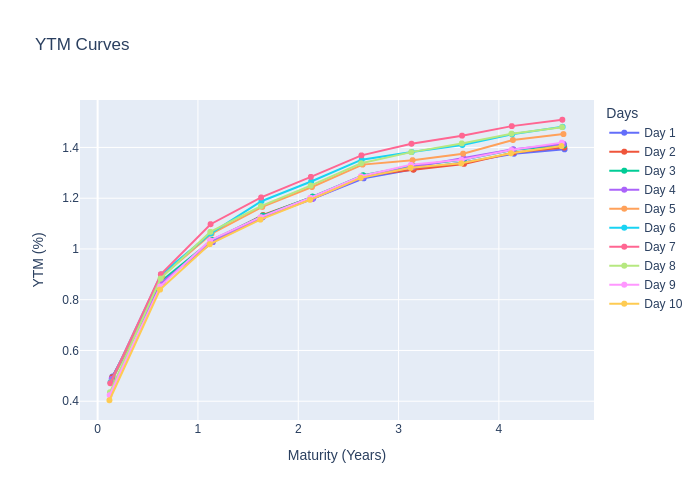

In [54]:
combined_ytm = []
fig = go.Figure()
for i, bonds in enumerate(combined_bonds):
    ytm_rates = approximate_ytm_semiannual(bonds)
    combined_ytm.append(ytm_rates)
    maturities = [bond[2] for bond in bonds]
    fig.add_trace(
        go.Scatter(
            x=maturities,
            y=ytm_rates * 100,
            mode='lines+markers',
            name=f'Day {i + 1}' 
        )
    )

# Update the layout
fig.update_layout(
    title='YTM Curves',
    xaxis_title='Maturity (Years)',
    yaxis_title='YTM (%)',
    legend_title='Days'
)

# Show the figure
fig.show()

### b

In [55]:
def bootstrap_yield_curve(bonds):
    spot_rates = np.zeros(len(bonds))
    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
        coupon_payment = (coupon_rate) / 2  # Semi-annual coupon payment
        time_periods = []
        current = maturity
        while current > 0:
            time_periods.append(current)
            current -= 0.5
        cash_flows = np.array([coupon_payment] * (len(time_periods) - 1) + [100 + coupon_payment])
        if i == 0:
            # For the first bond (zero-coupon bond approximation)
            spot_rate = ((cash_flows[-1] / price) ** (1 / maturity)) - 1
        else:
            # For subsequent bonds, calculate based on previous spot rates
            time_periods = sorted(time_periods)
            discounted_cash_flows = np.sum(
                cash_flows[:-1] / (1 + spot_rates[:i] / 2) ** time_periods[:-1]
            )
            residual = price - discounted_cash_flows
            spot_rate = ((cash_flows[-1] / residual) ** (1 / maturity)) - 1

        spot_rates[i] = spot_rate

    return spot_rates

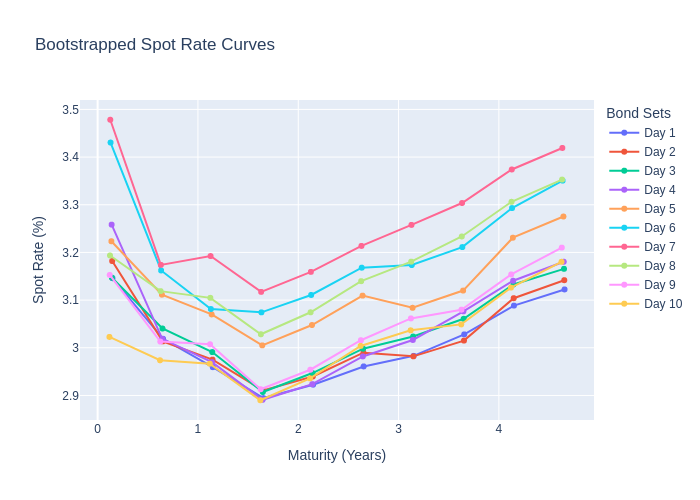

In [56]:
fig = go.Figure()
combined_spot_rates = []
for i, bonds in enumerate(combined_bonds):
    spot_rates = bootstrap_yield_curve(bonds)
    combined_spot_rates.append(spot_rates)
    maturities = [bond[2] for bond in bonds]
    
    fig.add_trace(
        go.Scatter(
            x=maturities,
            y=[sr*100 for sr in spot_rates],
            mode='lines+markers',
            name=f'Day {i + 1}'
        )
    )

# Update the layout
fig.update_layout(
    title='Bootstrapped Spot Rate Curves',
    xaxis_title='Maturity (Years)',
    yaxis_title='Spot Rate (%)',
    legend_title='Bond Sets'
)

# Show the figure
fig.show()


### c

In [57]:
def compute_forward_curve(maturities, spot_rates, t1_index = 2):
    forward_rates = []
    t1 = maturities[t1_index]
    indices = list(range(t1_index + 2, len(maturities), 2))
    if len(maturities) - 1 not in indices:
        indices.append(len(maturities) - 1)
    for t2_index in indices:
        t2 = maturities[t2_index]
        S_t1 = spot_rates[t1_index]
        S_t2 = spot_rates[t2_index]
        f_t1_t2 = ((1 + S_t2) ** (2*t2) / (1 + S_t1) ** (2*t1)) ** (1 / (2*(t2 - t1))) - 1
        forward_rates.append(f_t1_t2)
    return forward_rates

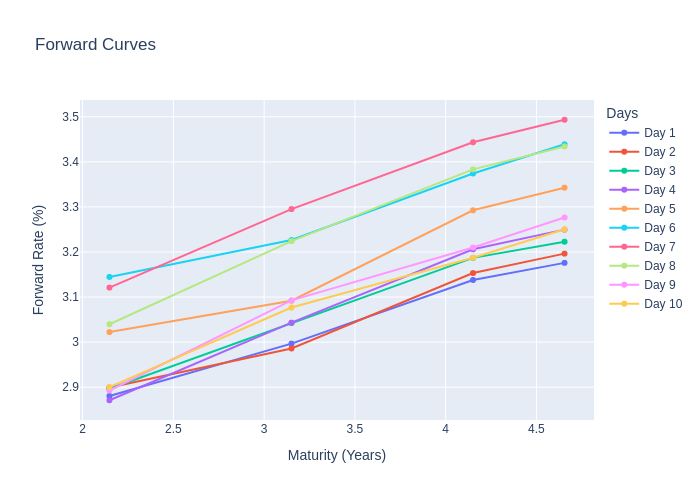

In [58]:
maturity = [bond[2] for bond in combined_bonds[0]]
combined_forward_rates = []
    
fig = go.Figure()
for i, spot_rates in enumerate(combined_spot_rates):
    forward_rates = compute_forward_curve(maturities = maturity, spot_rates = spot_rates, t1_index = 2)
    combined_forward_rates.append(forward_rates)
    fig.add_trace(
        go.Scatter(
            x=[maturity[i] for i in (4, 6, 8, 9)],
            y= [fr * 100 for fr in forward_rates],
            mode='lines+markers',
            name=f'Day {i + 1}'
        )
    )

fig.update_layout(
    title='Forward Curves',
    xaxis_title='Maturity (Years)',
    yaxis_title='Forward Rate (%)',
    legend_title='Days'
)

fig.show()


### Q5

In [59]:
ytmmatrix = np.array(combined_ytm)
ytm_matrix = ytmmatrix[:, 2:]
ytm_cols = ytm_matrix[:, ::2]
last_col = ytm_matrix[:, -1:]
ytm_cols = np.hstack((ytm_cols, last_col))
ytm_log_returns = np.log(ytm_cols[1:]/ytm_cols[:-1]).T
ytm_cov = np.cov(ytm_log_returns)
ytm_cov

array([[0.00052914, 0.0004891 , 0.00043587, 0.00047008, 0.00044508],
       [0.0004891 , 0.00055256, 0.00046346, 0.00049918, 0.00048875],
       [0.00043587, 0.00046346, 0.00045669, 0.00046451, 0.00044929],
       [0.00047008, 0.00049918, 0.00046451, 0.0005027 , 0.00048506],
       [0.00044508, 0.00048875, 0.00044929, 0.00048506, 0.0004726 ]])

In [60]:
formatrix = np.array(combined_forward_rates)
foward_log_returns = np.log(formatrix[1:]/formatrix[:-1]).T
foward_cov = np.cov(foward_log_returns)
foward_cov

array([[0.00094286, 0.0006136 , 0.00064978, 0.00064486],
       [0.0006136 , 0.00062928, 0.00058056, 0.00055313],
       [0.00064978, 0.00058056, 0.00062485, 0.00059077],
       [0.00064486, 0.00055313, 0.00059077, 0.00056656]])

### Q6

In [61]:
yield_EVL, yield_EVT = np.linalg.eig(ytm_cov)

print("Eigenvalues for Covariance Matrix of Yield:")
for i, eigenvalue in enumerate(yield_EVL, 1):
    print(f"  {i}: {eigenvalue:.4f}")
print("\n")
print("Eigenvectors for Covariance Matrix of Yield:")
for i, eigenvector in enumerate(yield_EVT.T, 1):
    print(f"  {i}: {eigenvector}")

Eigenvalues for Covariance Matrix of Yield:
  1: 0.0024
  2: 0.0001
  3: 0.0000
  4: 0.0000
  5: 0.0000


Eigenvectors for Covariance Matrix of Yield:
  1: [-0.44523093 -0.46879946 -0.42618421 -0.4549137  -0.43979202]
  2: [ 0.86218654 -0.00927511 -0.30511327 -0.22138124 -0.33829659]
  3: [ 0.21334425 -0.83491592  0.4658963   0.20025949  0.01537599]
  4: [-0.10742796  0.12103556 -0.00078535  0.67608429 -0.71883172]
  5: [ 0.03670481 -0.26154703 -0.71289055  0.49684006  0.41854861]


In [62]:
foward_EVL, foward_EVT = np.linalg.eig(foward_cov)

print("Eigenvalues for Cov Matrix of Forward Rates:")
for i, eigenvalue in enumerate(foward_EVL, 1):
    print(f"  {i}: {eigenvalue:.4f}")
print("\n")
print("Eigenvectors for Cov Matrix of Forward Rates:")
for i, eigenvector in enumerate(foward_EVT.T, 1):
    print(f"  {i}: {eigenvector}")

Eigenvalues for Cov Matrix of Forward Rates:
  1: 0.0025
  2: 0.0002
  3: 0.0001
  4: 0.0000


Eigenvectors for Cov Matrix of Forward Rates:
  1: [0.57158134 0.46970225 0.48428703 0.46705529]
  2: [ 0.8004858  -0.48460435 -0.30649072 -0.17448365]
  3: [-0.16075998 -0.73785891  0.5182949   0.40136126]
  4: [-0.0816914  -0.01013175 -0.63474397  0.76832542]
